In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd drive/MyDrive/Sapienza/DL

/content/drive/MyDrive/Sapienza/DL


In [3]:
import pickle
import pandas as pd
import numpy as np
import json
import itertools
import gensim
path="SEMEVAL-2021-task6-corpus/data/"


In [4]:
with open('training_task3_images.pkl', 'rb') as handle:
    images = pickle.load(handle)

with open('training_task3_texts.pkl', 'rb') as handle:
    texts = pickle.load(handle)

with open('training_task3_labels_onehot.pkl', 'rb') as handle:
    train_labs = pickle.load(handle)

with open('training_task3_labels_string.pkl', 'rb') as handle:
    train_labs_str = pickle.load(handle)

with open('task3_all_labels.pkl', 'rb') as handle:
    all_labs = pickle.load(handle)



with open('dev_task3_images.pkl', 'rb') as handle:
    dev_images = pickle.load(handle)

with open('dev_task3_texts.pkl', 'rb') as handle:
    dev_texts = pickle.load(handle)

with open('dev_task3_labels_onehot.pkl', 'rb') as handle:
    dev_labs = pickle.load(handle)

with open('dev_task3_labels_string.pkl', 'rb') as handle:
    dev_labs_str = pickle.load(handle)



In [5]:
!nvidia-smi

Fri Feb 18 16:23:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
from keras.models import Model
from keras.layers import *
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2

inp = Input((224,224,3))

x=Conv2D(64,5,activation='relu', kernel_regularizer=l2(0.01))(inp)
x=MaxPooling2D()(x)
x=BatchNormalization()(x)

x=Conv2D(128,5,activation='relu', kernel_regularizer=l2(0.01))(x)
x=MaxPooling2D()(x)
x=BatchNormalization()(x)

x=Flatten()(x)

#x=TimeDistributed(x)(inp)

#x=LSTM(32)(x)
#x=Flatten()(x)
x=Dropout(0.4)(x)
x = Dense(512,activation='relu',name='feats')(x) 
out = Dense(len(all_labs),activation='sigmoid',name='classes')(x)

model = Model(inp, out)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 220, 220, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 64)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 110, 110, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 106, 106, 128)     204928    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 128)      0     

In [14]:
model=None

In [7]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

model.compile(optimizer = 'adam', loss = ['binary_crossentropy'],metrics=['categorical_accuracy'])

callbacks = [
    ReduceLROnPlateau(),
    EarlyStopping(patience=10, monitor='val_loss',mode="min")
]

history=model.fit(images,train_labs,
                  validation_data=([dev_images,dev_labs]), shuffle=True, epochs=50, batch_size=16, callbacks=callbacks)

Epoch 1/50
43/43 [==============================] - 15s 274ms/step - loss: 8.1904 - categorical_accuracy: 0.1659 - val_loss: 29.0856 - val_categorical_accuracy: 0.1111 - lr: 0.0010
Epoch 2/50
43/43 [==============================] - 8s 191ms/step - loss: 3.3648 - categorical_accuracy: 0.2649 - val_loss: 22.6073 - val_categorical_accuracy: 0.0794 - lr: 0.0010
Epoch 3/50
43/43 [==============================] - 8s 192ms/step - loss: 1.8070 - categorical_accuracy: 0.3726 - val_loss: 13.6095 - val_categorical_accuracy: 0.0952 - lr: 0.0010
Epoch 4/50
43/43 [==============================] - 8s 191ms/step - loss: 1.2631 - categorical_accuracy: 0.4323 - val_loss: 8.1642 - val_categorical_accuracy: 0.1429 - lr: 0.0010
Epoch 5/50
43/43 [==============================] - 8s 192ms/step - loss: 1.0285 - categorical_accuracy: 0.4134 - val_loss: 6.7369 - val_categorical_accuracy: 0.1587 - lr: 0.0010
Epoch 6/50
43/43 [==============================] - 8s 195ms/step - loss: 0.8663 - categorical_accura

In [ ]:
# CNN 43/43 [==============================] - 10s 236ms/step - loss: 0.0422 - categorical_accuracy: 0.4731 - val_loss: 5.6383 - val_categorical_accuracy: 0.1587



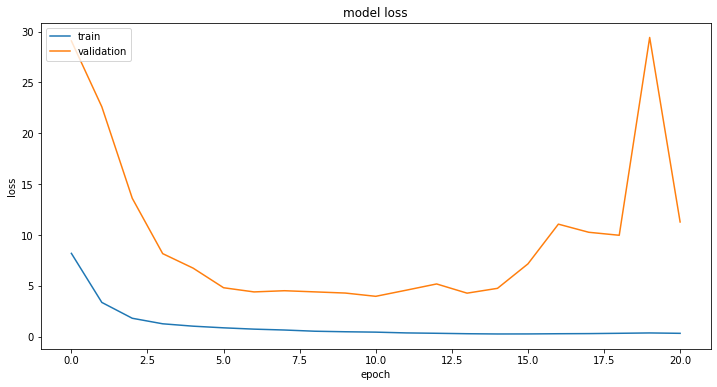

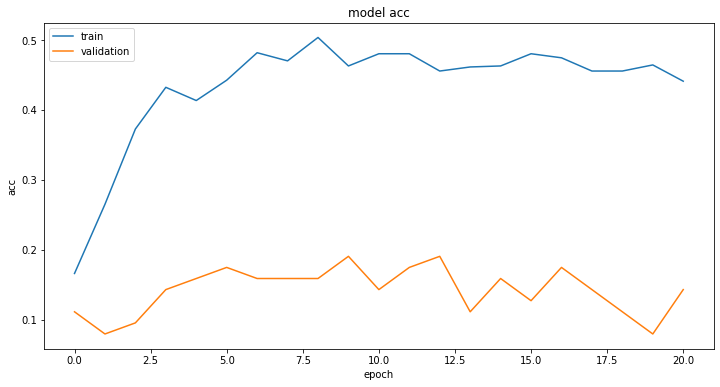

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline


# plotting the validation and training loss i.e. "mean absolute error"
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.figure(figsize=(12,6))

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])

plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [11]:
from keras.models import Model

feature_network = Model(model.input, model.get_layer('feats').output)
X_train = feature_network.predict(images)

X_train.shape

(687, 512)

In [13]:
X_valid = feature_network.predict(dev_images)
X_valid.shape

(63, 512)

In [14]:
y_train=train_labs
y_valid=dev_labs

In [18]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

log_reg = LogisticRegression(C = 10, penalty='l2', solver = 'liblinear', random_state=42)

one_vs_rest = OneVsRestClassifier(log_reg)
one_vs_rest.fit(X_train, y_train)

y_train_pred_proba = one_vs_rest.predict_proba(X_train)
y_valid_pred_proba = one_vs_rest.predict_proba(X_valid)

y_pred = (y_train_pred_proba > 0.3) 
y_train_new=(y_train > 0.3) 

print("Training accuracy: ", accuracy_score(y_train_new, y_pred))

y_pred1 = (y_valid_pred_proba > 0.3) 
y_dev_new=(y_valid > 0.3) 

print("Validation Accuracy: ", accuracy_score(y_dev_new, y_pred1))

from sklearn.metrics import classification_report, f1_score

print("Weighted F1 score: ", f1_score(y_dev_new,y_pred1,average='weighted'))
print("Micro F1 score: ", f1_score(y_dev_new,y_pred1,average='micro'))
print("Macro F1 score: ", f1_score(y_dev_new,y_pred1,average='macro'))

Training accuracy:  1.0
Validation Accuracy:  0.1111111111111111
Weighted F1 score:  0.4086188602317634
Micro F1 score:  0.4702194357366771
Macro F1 score:  0.11794702881659404


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [21]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

log_reg = LogisticRegression(C = 1, penalty='l2', solver = 'liblinear', random_state=42)

one_vs_rest = OneVsRestClassifier(log_reg)
one_vs_rest.fit(X_train, y_train)

y_train_pred_proba = one_vs_rest.predict_proba(X_train)
y_valid_pred_proba = one_vs_rest.predict_proba(X_valid)

y_pred = (y_train_pred_proba > 0.2) 
y_train_new=(y_train > 0.2) 

print("Training accuracy: ", accuracy_score(y_train_new, y_pred))

y_pred1 = (y_valid_pred_proba > 0.2) 
y_dev_new=(y_valid > 0.2) 

print("Validation Accuracy: ", accuracy_score(y_dev_new, y_pred1))

from sklearn.metrics import classification_report, f1_score

print("Weighted F1 score: ", f1_score(y_dev_new,y_pred1,average='weighted'))
print("Micro F1 score: ", f1_score(y_dev_new,y_pred1,average='micro'))
print("Macro F1 score: ", f1_score(y_dev_new,y_pred1,average='macro'))

Training accuracy:  1.0
Validation Accuracy:  0.12698412698412698
Weighted F1 score:  0.4144128641465665
Micro F1 score:  0.4814814814814815
Macro F1 score:  0.11921324585504392


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [23]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

log_reg = LogisticRegression(C = 20, penalty='l2', solver = 'lbfgs', random_state=42)

one_vs_rest = OneVsRestClassifier(log_reg)
one_vs_rest.fit(X_train, y_train)

y_train_pred_proba = one_vs_rest.predict_proba(X_train)
y_valid_pred_proba = one_vs_rest.predict_proba(X_valid)

y_pred = (y_train_pred_proba > 0.2) 
y_train_new=(y_train > 0.2) 

print("Training accuracy: ", accuracy_score(y_train_new, y_pred))

y_pred1 = (y_valid_pred_proba > 0.2) 
y_dev_new=(y_valid > 0.2) 

print("Validation Accuracy: ", accuracy_score(y_dev_new, y_pred1))

from sklearn.metrics import classification_report, f1_score

print("Weighted F1 score: ", f1_score(y_dev_new,y_pred1,average='weighted'))
print("Micro F1 score: ", f1_score(y_dev_new,y_pred1,average='micro'))
print("Macro F1 score: ", f1_score(y_dev_new,y_pred1,average='macro'))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Training accuracy:  1.0
Validation Accuracy:  0.1111111111111111
Weighted F1 score:  0.4018748368583729
Micro F1 score:  0.46394984326018807
Macro F1 score:  0.13309985594851778


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [25]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

rnd = RandomForestClassifier(n_estimators=60,n_jobs=-1)

one_vs_rest = OneVsRestClassifier(rnd)
one_vs_rest.fit(X_train, y_train)

y_train_pred_proba = one_vs_rest.predict_proba(X_train)
y_valid_pred_proba = one_vs_rest.predict_proba(X_valid)

y_pred = (y_train_pred_proba > 0.3) 
y_train_new=(y_train > 0.3) 

print("Training accuracy: ", accuracy_score(y_train_new, y_pred))

y_pred1 = (y_valid_pred_proba > 0.3) 
y_dev_new=(y_valid > 0.3) 

print("Validation Accuracy: ", accuracy_score(y_dev_new, y_pred1))

print("Weighted F1 score: ", f1_score(y_dev_new,y_pred1,average='weighted'))
print("Micro F1 score: ", f1_score(y_dev_new,y_pred1,average='micro'))
print("Macro F1 score: ", f1_score(y_dev_new,y_pred1,average='macro'))

Training accuracy:  0.9810771470160117
Validation Accuracy:  0.14285714285714285
Weighted F1 score:  0.428930408500301
Micro F1 score:  0.5650969529085873
Macro F1 score:  0.09265956802188687


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
